<a href="https://colab.research.google.com/github/francescovenco000004/VAE-collection/blob/main/VAE_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying to figure out what part of the conditional beta VAE doesnt work.

# 1. Vanilla VAE:
training data shape: (17740, 25)


hyperparamters:

hidden_dim1=64,

hidden_dim2=32,

z_dim=10

optimizer = Adam,

lr=1e-4

epochs=50

batch size = 128


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
# Change to the project directory
project_path = "/content/drive/My Drive/beta-VAE/.3_new_data/model_directory"
os.chdir(project_path)

# Verify the current working directory

print("Current Working Directory: ", os.getcwd())
import sys

sys.path.append(project_path)

# Verify that the project path is in the Python path
print("Python Path: ", sys.path)

Mounted at /content/drive
Current Working Directory:  /content/drive/My Drive/beta-VAE/.3_new_data/model_directory
Python Path:  ['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/My Drive/beta-VAE/.3_new_data/model_directory']


In [ ]:
print(df.head())

   Subject  NoChoice  female  math  PointIQ  PointIE  SE   B5Extra   B5Agree  \
0        1         1       0     1       11       25  28  5.166666  6.333333   
1        1         2       0     1       11       25  28  5.166666  6.333333   
2        1         3       0     1       11       25  28  5.166666  6.333333   
3        1         4       0     1       11       25  28  5.166666  6.333333   
4        1         5       0     1       11       25  28  5.166666  6.333333   

    B5Consc  ...  TPmiss  NTPmiss  REV{NoChoice}a  REV{NoChoice}b  Choices  \
0  2.833333  ...       0        0           -11.6          -12.65      0.0   
1  2.833333  ...       0        0           -11.4          -13.25      0.0   
2  2.833333  ...       0        0           -12.4          -13.80      0.0   
3  2.833333  ...       0        0           -13.4          -15.60      0.0   
4  2.833333  ...       0        0           -11.2          -12.20      0.0   

   RoundProbValue  TimeNext  TP  EvDiff  D_SetProm

In [ ]:
import numpy as np
# Check if there are any NaN values in the data
print(df.isnull().sum())  # This will show if any column has NaN values

# Alternatively, you can check if any values are infinite (infinite values could cause NaNs)
print((~np.isfinite(df)).sum())  # This checks for infinite values in the dataframe


NoChoice             0
female               0
math                 0
PointIQ              0
PointIE              0
SE                   0
B5Extra              0
B5Agree              0
B5Consc              0
B5Emot               0
B5Open               0
violator             0
TPfirst              0
swiftness            0
IQfirst              0
TPmiss               0
NTPmiss              0
REV{NoChoice}a       0
REV{NoChoice}b       0
Choices            266
RoundProbValue       0
TimeNext           273
TP                   0
EvDiff               0
D_SetProminGain      0
dtype: int64
NoChoice             0
female               0
math                 0
PointIQ              0
PointIE              0
SE                   0
B5Extra              0
B5Agree              0
B5Consc              0
B5Emot               0
B5Open               0
violator             0
TPfirst              0
swiftness            0
IQfirst              0
TPmiss               0
NTPmiss              0
REV{NoChoice}a       

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assume df has been pre-processed and loaded
df = pd.read_csv("Variables Codebook and training data.xlsx - Sheet3.csv")
df = df.drop('Subject', axis=1)
df.drop('NoChoice', axis=1)



#drop empty 'choice' observations
df.dropna(subset=['Choices'], inplace=True)
print(df.shape)

#add avergae response times for missing values
#df['col_name'].fillna(value=8.398, inplace=True)
df.dropna(subset=['TimeNext'], inplace = True)
print(df.shape)



# Scale/normalize the trial and participant features
scaler_trial = StandardScaler()
X = scaler_trial.fit_transform(df)


# Convert the NumPy array to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)

# Optionally split the data into train and validation sets
X_train, X_val = train_test_split(X_tensor, test_size=0.2, random_state=42)

# Create PyTorch Dataset and DataLoader
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)

val_dataset = TensorDataset(X_val)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)


(17926, 25)
(17740, 25)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [ ]:
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, z_dim)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)

        # Clamp logvar to prevent instability (example: between -10 and 10)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        x_recon = self.fc3(h)
        return x_recon



class BetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, z_dim):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim2, hidden_dim1, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)   # Convert log variance to standard deviation
        eps = torch.randn_like(std)     # Sample epsilon from N(0, 1)
        return mu + eps * std           # Reparameterization trick

    def forward(self, x):
        mu, logvar = self.encoder(x)    # Encode input into mu and logvar
        z = self.reparameterize(mu, logvar)  # Sample z using reparameterization
        x_recon = self.decoder(z)       # Reconstruct the input from latent z
        return x_recon, mu, logvar      # Return reconstruction, mu, and logvar

    def loss_function(self, x, x_recon, mu, logvar):
        # Using binary cross entropy with logits and mean reduction
        recon_loss = F.mse_loss(x_recon, x, reduction='mean')

        # KL Divergence loss
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


        # Return combined loss with beta scaling KL divergence
        return recon_loss + kl_div


In [ ]:
import torch
from torch.cuda.amp import GradScaler
from torch.optim import Adam

# Set up the model, optimizer, and scaler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)  # Xavier initialization for weights
        if m.bias is not None:
            m.bias.data.fill_(0.01)  # Initialize biases to small values


# Assuming you have your input dimensions set
model = BetaVAE(input_dim=X_train.shape[1], hidden_dim1=64, hidden_dim2=32, z_dim=10).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()

model.apply(init_weights)

# Training Loop
num_epochs = 50
save_path = './vanilla_vae_model.pth'

model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data,) in enumerate(train_loader):  # Adjust to match single input
        data = data.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            x_recon, mu, logvar = model(data)  # Pass the input data to the model
            loss = model.loss_function(data, x_recon, mu, logvar)

        # Backward pass with mixed precision scaling
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Save the model after each epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, save_path)
    print(f"Model saved after epoch {epoch+1} at {save_path}")


<ipython-input-14-cfd714c542a5>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-14-cfd714c542a5>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50], Loss: 1.2098
Model saved after epoch 1 at ./vanilla_vae_model.pth
Epoch [2/50], Loss: 0.3885
Model saved after epoch 2 at ./vanilla_vae_model.pth
Epoch [3/50], Loss: 0.1231
Model saved after epoch 3 at ./vanilla_vae_model.pth
Epoch [4/50], Loss: 0.0368
Model saved after epoch 4 at ./vanilla_vae_model.pth
Epoch [5/50], Loss: 0.0133
Model saved after epoch 5 at ./vanilla_vae_model.pth
Epoch [6/50], Loss: 0.0088
Model saved after epoch 6 at ./vanilla_vae_model.pth
Epoch [7/50], Loss: 0.0083
Model saved after epoch 7 at ./vanilla_vae_model.pth
Epoch [8/50], Loss: 0.0080
Model saved after epoch 8 at ./vanilla_vae_model.pth
Epoch [9/50], Loss: 0.0082
Model saved after epoch 9 at ./vanilla_vae_model.pth
Epoch [10/50], Loss: 0.0084
Model saved after epoch 10 at ./vanilla_vae_model.pth
Epoch [11/50], Loss: 0.0082
Model saved after epoch 11 at ./vanilla_vae_model.pth
Epoch [12/50], Loss: 0.0082
Model saved after epoch 12 at ./vanilla_vae_model.pth
Epoch [13/50], Loss: 0.0081
Model 

In [ ]:
model.eval()  # Set the model to evaluation mode
val_loss = 0
with torch.no_grad():  # Disable gradient calculation for testing
    for batch_idx, (data,) in enumerate(val_loader):  # Loop through validation data
        data = data.to(device)

        # Forward pass through the model
        x_recon, mu, logvar = model(data)

        # Calculate the loss (reconstruction + KL divergence)
        loss = model.loss_function(data, x_recon, mu, logvar)

        # Accumulate the validation loss
        val_loss += loss.item()

# Calculate average validation loss
avg_val_loss = val_loss / len(val_loader.dataset)
print(f'Validation Loss: {avg_val_loss:.4f}')


Validation Loss: 0.0081


In [ ]:
import torch

model_path = './vanilla_vae_model.pth'  # Path to the saved checkpoint

# Set device to CPU
device = torch.device('cpu')

# Initialize the model architecture
model = BetaVAE(input_dim=X_train.shape[1], hidden_dim1=64, hidden_dim2=32, z_dim=10).to(device)

# Load the checkpoint
checkpoint = torch.load(model_path, map_location=device)

# Load the model's state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()
print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-17-46f374f111cb>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


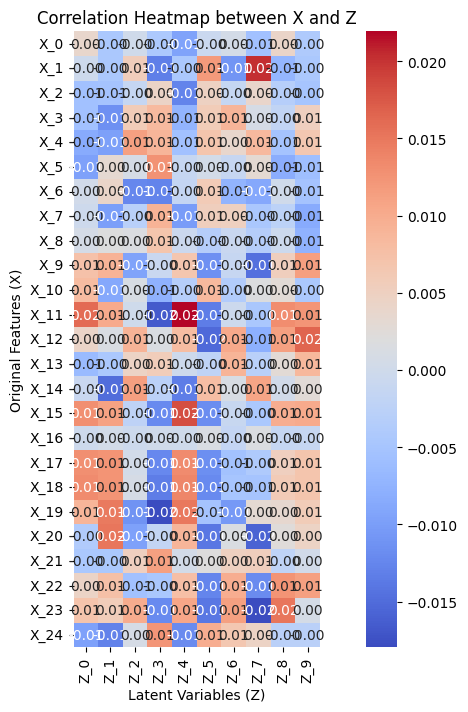

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set model to evaluation mode
model.eval()

# Assuming `X_tensor` is your full input dataset as a PyTorch tensor
X_tensor = X_tensor.to(device)

# Get latent representations (mu and logvar) from the encoder
with torch.no_grad():
    mu, logvar = model.encoder(X_tensor)  # Only get mu and logvar

# Convert to NumPy for easier manipulation
X_numpy = X_tensor.cpu().numpy()
Z_numpy = mu.cpu().numpy()  # Use mu for latent representation

# Convert to pandas DataFrames
X_df = pd.DataFrame(X_numpy, columns=[f"X_{i}" for i in range(X_numpy.shape[1])])
Z_df = pd.DataFrame(Z_numpy, columns=[f"Z_{i}" for i in range(Z_numpy.shape[1])])

# Concatenate X and Z for direct correlation analysis
combined_df = pd.concat([X_df, Z_df], axis=1)

# Compute the correlation matrix
correlation_matrix = combined_df.corr()

# Extract only the correlations between X and Z
correlation_matrix_xz = correlation_matrix.iloc[:X_df.shape[1], X_df.shape[1]:]

# Visualize the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_xz, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap between X and Z")
plt.xlabel('Latent Variables (Z)')
plt.ylabel('Original Features (X)')
plt.show()


Summary Statistics for Latent Variables:
Latent Variable Z_0: Mean = 0.0000, Std Dev = 0.0005
Latent Variable Z_1: Mean = 0.0000, Std Dev = 0.0004
Latent Variable Z_2: Mean = 0.0000, Std Dev = 0.0004
Latent Variable Z_3: Mean = -0.0000, Std Dev = 0.0003
Latent Variable Z_4: Mean = 0.0000, Std Dev = 0.0004
Latent Variable Z_5: Mean = -0.0000, Std Dev = 0.0004
Latent Variable Z_6: Mean = 0.0000, Std Dev = 0.0005
Latent Variable Z_7: Mean = 0.0000, Std Dev = 0.0003
Latent Variable Z_8: Mean = 0.0000, Std Dev = 0.0005
Latent Variable Z_9: Mean = 0.0000, Std Dev = 0.0004


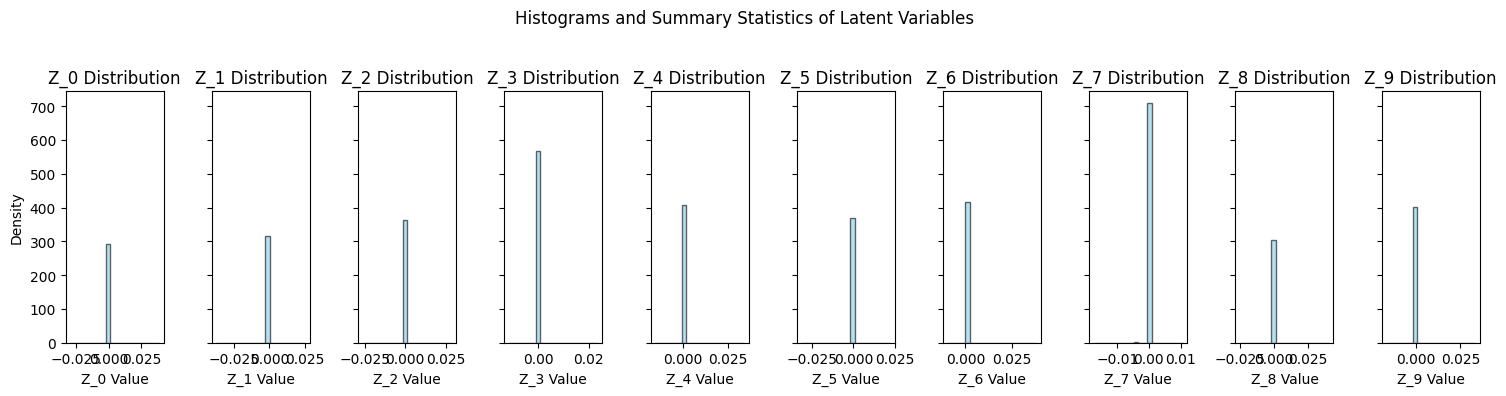

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming `z` is the latent representation (e.g., `mu` from the encoder) for all `X_tensor` data

# # Convert `z` to a numpy array for easier manipulation if it’s not already
# z_numpy = z.cpu().numpy() if isinstance(z, torch.Tensor) else z

# Calculate summary statistics
means = np.mean(Z_numpy, axis=0)
std_devs = np.std(Z_numpy, axis=0)

# Print the summary statistics
print("Summary Statistics for Latent Variables:")
for i in range(Z_numpy.shape[1]):
    print(f"Latent Variable Z_{i}: Mean = {means[i]:.4f}, Std Dev = {std_devs[i]:.4f}")

# Plot histograms for each latent variable
num_latent_vars = Z_numpy.shape[1]
fig, axes = plt.subplots(1, num_latent_vars, figsize=(15, 4), sharey=True)

for i in range(num_latent_vars):
    ax = axes[i]
    ax.hist(Z_numpy[:, i], bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    ax.set_title(f"Z_{i} Distribution")
    ax.set_xlabel(f"Z_{i} Value")
    ax.set_ylabel("Density" if i == 0 else "")  # Add y-label only to the first plot for clarity

plt.suptitle("Histograms and Summary Statistics of Latent Variables")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# 2. Conditional VAE:

x shape: (17740,8)

conditions shape: (17740, 17)


hyperparamters:

hidden_dim1=64,

hidden_dim2=32,

z_dim=10

optimizer = Adam,

lr=1e-4

epochs=50

batch size = 128


In [ ]:
df.columns

Index(['NoChoice', 'female', 'math', 'PointIQ', 'PointIE', 'SE', 'B5Extra',
       'B5Agree', 'B5Consc', 'B5Emot', 'B5Open', 'violator', 'TPfirst',
       'swiftness', 'IQfirst', 'TPmiss', 'NTPmiss', 'REV{NoChoice}a',
       'REV{NoChoice}b', 'Choices', 'RoundProbValue', 'TimeNext', 'TP',
       'EvDiff', 'D_SetProminGain'],
      dtype='object')

In [ ]:
# Assuming df contains both lottery details and personal attributes
# Example: Lottery data (choices, time) in X_lottery, personal attributes in X_personal

# Separate into main input and condition variables
X_lottery = df[['REV{NoChoice}a','REV{NoChoice}b', 'Choices', 'RoundProbValue', 'TimeNext', 'TP','EvDiff', 'D_SetProminGain']].values
X_personal = df[['NoChoice', 'female', 'math', 'PointIQ', 'PointIE', 'SE', 'B5Extra','B5Agree', 'B5Consc', 'B5Emot', 'B5Open', 'violator', 'TPfirst','swiftness', 'IQfirst', 'TPmiss', 'NTPmiss']].values

# Scale/normalize both parts separately
scaler_lottery = StandardScaler()
X_lottery_scaled = scaler_lottery.fit_transform(X_lottery)

scaler_personal = StandardScaler()
X_personal_scaled = scaler_personal.fit_transform(X_personal)

# Convert to PyTorch tensors
X_lottery_tensor = torch.tensor(X_lottery_scaled, dtype=torch.float32)
X_personal_tensor = torch.tensor(X_personal_scaled, dtype=torch.float32)

# Concatenate the tensors for training
train_lottery, val_lottery, train_personal, val_personal = train_test_split(
    X_lottery_tensor, X_personal_tensor, test_size=0.2, random_state=42
)

# Create a new dataset with both inputs
train_dataset = TensorDataset(train_lottery, train_personal)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(val_lottery, val_personal)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim1, hidden_dim2, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + cond_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, z_dim)

    def forward(self, x, cond):
        # Concatenate main input with conditional variables
        x_cond = torch.cat([x, cond], dim=-1)
        h1 = F.relu(self.fc1(x_cond))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)

        # Clamp logvar to prevent instability
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, cond_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim + cond_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, z, cond):
        # Concatenate latent variable z with conditional variables
        z_cond = torch.cat([z, cond], dim=-1)
        h = F.relu(self.fc1(z_cond))
        h = F.relu(self.fc2(h))
        x_recon = self.fc3(h)
        return x_recon


In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim1, hidden_dim2, z_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, cond_dim, hidden_dim1, hidden_dim2, z_dim)
        self.decoder = Decoder(z_dim, cond_dim, hidden_dim1, hidden_dim2, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, cond):
        # Encode input and condition into mu and logvar
        mu, logvar = self.encoder(x, cond)
        # Sample from the latent space
        z = self.reparameterize(mu, logvar)
        # Decode back to reconstruct input, conditioned on the same variables
        x_recon = self.decoder(z, cond)
        return x_recon, mu, logvar

    def loss_function(self, x, x_recon, mu, logvar):
        # Reconstruction loss
        recon_loss = F.mse_loss(x_recon, x, reduction='mean')
        # KL divergence
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div


In [ ]:

import torch
from torch.cuda.amp import GradScaler
from torch.optim import Adam

# Set up the model, optimizer, and scaler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)  # Xavier initialization for weights
        if m.bias is not None:
            m.bias.data.fill_(0.01)  # Initialize biases to small values


# Set up the model
cond_dim = train_personal.shape[1]  # The dimension of the conditional variables (e.g., IQ, personality traits)
model = ConditionalVAE(input_dim=train_lottery.shape[1], cond_dim=cond_dim, hidden_dim1=64, hidden_dim2=32, z_dim=5).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()


model.apply(init_weights)

# Training Loop
num_epochs = 50
save_path = './conditional_vae_model.pth'

# Training loop
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (lottery_data, personal_data) in enumerate(train_loader):
        lottery_data, personal_data = lottery_data.to(device), personal_data.to(device)

        optimizer.zero_grad()

        # Forward pass
        with torch.cuda.amp.autocast():
            x_recon, mu, logvar = model(lottery_data, personal_data)
            loss = model.loss_function(lottery_data, x_recon, mu, logvar)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


<ipython-input-13-bfe4d4a71fc7>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-13-bfe4d4a71fc7>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50], Loss: 1.0501
Epoch [2/50], Loss: 0.4313
Epoch [3/50], Loss: 0.2644
Epoch [4/50], Loss: 0.1866
Epoch [5/50], Loss: 0.1412
Epoch [6/50], Loss: 0.1111
Epoch [7/50], Loss: 0.0897
Epoch [8/50], Loss: 0.0738
Epoch [9/50], Loss: 0.0616
Epoch [10/50], Loss: 0.0520
Epoch [11/50], Loss: 0.0443
Epoch [12/50], Loss: 0.0381
Epoch [13/50], Loss: 0.0329
Epoch [14/50], Loss: 0.0287
Epoch [15/50], Loss: 0.0251
Epoch [16/50], Loss: 0.0222
Epoch [17/50], Loss: 0.0197
Epoch [18/50], Loss: 0.0176
Epoch [19/50], Loss: 0.0158
Epoch [20/50], Loss: 0.0144
Epoch [21/50], Loss: 0.0131
Epoch [22/50], Loss: 0.0121
Epoch [23/50], Loss: 0.0112
Epoch [24/50], Loss: 0.0105
Epoch [25/50], Loss: 0.0099
Epoch [26/50], Loss: 0.0094
Epoch [27/50], Loss: 0.0089
Epoch [28/50], Loss: 0.0086
Epoch [29/50], Loss: 0.0082
Epoch [30/50], Loss: 0.0080
Epoch [31/50], Loss: 0.0077
Epoch [32/50], Loss: 0.0075
Epoch [33/50], Loss: 0.0073
Epoch [34/50], Loss: 0.0070
Epoch [35/50], Loss: 0.0068
Epoch [36/50], Loss: 0.0068
E

In [ ]:
model.eval()  # Set the model to evaluation mode
val_loss = 0
with torch.no_grad():  # Disable gradient calculation for testing
    for batch_idx, (lottery_data, personal_data) in enumerate(val_loader):  # Loop through validation data
        lottery_data = lottery_data.to(device)
        personal_data = personal_data.to(device)

        # Forward pass through the model with both inputs and conditional variables
        x_recon, mu, logvar = model(lottery_data, personal_data)

        # Calculate the loss (reconstruction + KL divergence)
        loss = model.loss_function(lottery_data, x_recon, mu, logvar)

        # Accumulate the validation loss
        val_loss += loss.item()

# Calculate average validation loss
avg_val_loss = val_loss / len(val_loader.dataset)
print(f'Validation Loss: {avg_val_loss:.4f}')


Validation Loss: 0.0058


In [ ]:
# Save the entire model
torch.save(model, './conditional_vae_entire_model.pth')


# 3. Linearly increasing 𝛃 C-VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torch.optim import Adam

# Define Encoder, Decoder, and ConditionalVAE classes
class Encoder(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim1, hidden_dim2, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + cond_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, z_dim)

    def forward(self, x, cond):
        x_cond = torch.cat([x, cond], dim=-1)
        h1 = F.relu(self.fc1(x_cond))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, cond_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim + cond_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, z, cond):
        z_cond = torch.cat([z, cond], dim=-1)
        h = F.relu(self.fc1(z_cond))
        h = F.relu(self.fc2(h))
        x_recon = self.fc3(h)
        return x_recon

class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim1, hidden_dim2, z_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, cond_dim, hidden_dim1, hidden_dim2, z_dim)
        self.decoder = Decoder(z_dim, cond_dim, hidden_dim1, hidden_dim2, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, cond):
        mu, logvar = self.encoder(x, cond)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, cond)
        return x_recon, mu, logvar

    def loss_function(self, x, x_recon, mu, logvar, beta=1.0):
        # Reconstruction loss
        recon_loss = F.mse_loss(x_recon, x, reduction='mean')
        # KL divergence with beta factor
        kl_div = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div



In [ ]:

import torch
from torch.cuda.amp import GradScaler
from torch.optim import Adam

# Set up the model, optimizer, and scaler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)  # Xavier initialization for weights
        if m.bias is not None:
            m.bias.data.fill_(0.01)  # Initialize biases to small values


# Set up the model
cond_dim = train_personal.shape[1]  # The dimension of the conditional variables (e.g., IQ, personality traits)
model = ConditionalVAE(input_dim=train_lottery.shape[1], cond_dim=cond_dim, hidden_dim1=64, hidden_dim2=32, z_dim=5).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()


model.apply(init_weights)

# Training Loop
num_epochs = 50
save_path = './conditional_vae_model.pth'


# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cond_dim = train_personal.shape[1]
model = ConditionalVAE(input_dim=train_lottery.shape[1], cond_dim=cond_dim, hidden_dim1=64, hidden_dim2=32, z_dim=5).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()


num_epochs = 50
save_path = './beta_conditional_vae_model.pth'
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    # Linearly scale beta from 1.0 to 2.0 over the epochs
    beta = 1 + (epoch / num_epochs)

    for batch_idx, (lottery_data, personal_data) in enumerate(train_loader):
        lottery_data, personal_data = lottery_data.to(device), personal_data.to(device)
        optimizer.zero_grad()

        # Forward pass
        with torch.cuda.amp.autocast():
            x_recon, mu, logvar = model(lottery_data, personal_data)
            loss = model.loss_function(lottery_data, x_recon, mu, logvar, beta=beta)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Beta: {beta:.4f}')


<ipython-input-6-e6ae72b863a6>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-6-e6ae72b863a6>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-6-e6ae72b863a6>:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50], Loss: 0.0482, Beta: 1.0000
Epoch [2/50], Loss: 0.0201, Beta: 1.0200
Epoch [3/50], Loss: 0.0139, Beta: 1.0400
Epoch [4/50], Loss: 0.0117, Beta: 1.0600
Epoch [5/50], Loss: 0.0105, Beta: 1.0800
Epoch [6/50], Loss: 0.0097, Beta: 1.1000
Epoch [7/50], Loss: 0.0092, Beta: 1.1200
Epoch [8/50], Loss: 0.0088, Beta: 1.1400
Epoch [9/50], Loss: 0.0085, Beta: 1.1600
Epoch [10/50], Loss: 0.0082, Beta: 1.1800
Epoch [11/50], Loss: 0.0080, Beta: 1.2000
Epoch [12/50], Loss: 0.0077, Beta: 1.2200
Epoch [13/50], Loss: 0.0076, Beta: 1.2400
Epoch [14/50], Loss: 0.0074, Beta: 1.2600
Epoch [15/50], Loss: 0.0072, Beta: 1.2800
Epoch [16/50], Loss: 0.0071, Beta: 1.3000
Epoch [17/50], Loss: 0.0069, Beta: 1.3200
Epoch [18/50], Loss: 0.0068, Beta: 1.3400
Epoch [19/50], Loss: 0.0067, Beta: 1.3600
Epoch [20/50], Loss: 0.0067, Beta: 1.3800
Epoch [21/50], Loss: 0.0066, Beta: 1.4000
Epoch [22/50], Loss: 0.0065, Beta: 1.4200
Epoch [23/50], Loss: 0.0065, Beta: 1.4400
Epoch [24/50], Loss: 0.0065, Beta: 1.4600
E

In [ ]:
model.eval()  # Set the model to evaluation mode
val_loss = 0
with torch.no_grad():  # Disable gradient calculation for testing
    for batch_idx, (lottery_data, personal_data) in enumerate(val_loader):  # Loop through validation data
        lottery_data = lottery_data.to(device)
        personal_data = personal_data.to(device)

        # Forward pass through the model with both inputs and conditional variables
        x_recon, mu, logvar = model(lottery_data, personal_data)

        # Calculate the loss (reconstruction + KL divergence)
        loss = model.loss_function(lottery_data, x_recon, mu, logvar)

        # Accumulate the validation loss
        val_loss += loss.item()

# Calculate average validation loss
avg_val_loss = val_loss / len(val_loader.dataset)
print(f'Validation Loss: {avg_val_loss:.4f}')


Validation Loss: 0.0053


In [ ]:
# Save the entire model
torch.save(model, './3.beta-conditional_vae_entire_model.pth')